### This sample of code is not intended to get some specific results, it just shows some common steps in action
### In this code we do binary classification
### Put datasource file 'toydata.csv' to your current working directory

##### scikit-learn v.0.18.1

In [24]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import xgboost as xgb


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from tkinter import Tk
from tkinter.filedialog import askopenfilename

In [42]:
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, auc, confusion_matrix, classification_report

#### Utils block

In [6]:
def get_class_distribution(dt):
    val_counts = dt['L'].value_counts()
    class_rate = dt.L[dt['L']==1].shape[0]/dt.shape[0]
    return val_counts, class_rate

#### Reading toydata to work with

In [7]:
from tkinter import Tk
from tkinter.filedialog import askopenfilename

Tk().withdraw() 
filename = askopenfilename()
print(filename)

/mnt/files/workdata/work/scripts_R/toydata.csv


In [8]:
df = pd.read_csv(filename, header = 0)
df.head()

,F1,F2,F3,F4,F5,B1,B2,F6,F7,L
0,264.75,840,552872,1,21,1,1,117.0,7.0,0
1,21.18,840,707540,2,16,1,1,119.0,7.0,0
2,200.68,840,522345,1,7,1,1,126.0,-30.0,0
3,53.16,840,715280,2,19,1,1,128.0,-7.0,0
4,52.95,840,147595,6,5,1,1,131.0,16.0,0


#### first-look at loaded data

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7698 entries, 0 to 7697
Data columns (total 10 columns):
F1    7698 non-null float64
F2    7698 non-null int64
F3    7698 non-null int64
F4    7698 non-null int64
F5    7698 non-null int64
B1    7698 non-null int64
B2    7698 non-null int64
F6    7661 non-null float64
F7    7661 non-null float64
L     7698 non-null int64
dtypes: float64(3), int64(7)
memory usage: 601.5 KB


In [10]:
df.describe()

,F1,F2,F3,F4,F5,B1,B2,F6,F7,L
count,7698.000000,7698.000000,7698.000000,7698.000000,7698.000000,7698.000000,7698.000000,7661.000000,7661.000000,7698.000000
mean,107.088290,794.799948,405657.562744,4.418161,10.755001,0.962198,0.985840,125.512205,-1.360919,0.356586
std,183.118465,169.730588,233638.625641,1.978806,7.858714,0.190730,0.118156,11.812571,19.351224,0.479022
min,2.360000,32.000000,2551.000000,1.000000,0.000000,0.000000,0.000000,46.000000,-70.000000,0.000000
25%,26.182500,840.000000,220082.500000,3.000000,4.000000,1.000000,1.000000,125.000000,-7.000000,0.000000
50%,47.335000,840.000000,465175.000000,5.000000,8.000000,1.000000,1.000000,128.000000,-7.000000,0.000000
75%,105.900000,840.000000,551780.000000,6.000000,19.000000,1.000000,1.000000,130.000000,7.000000,1.000000
max,1500.000000,840.000000,997540.000000,7.000000,23.000000,1.000000,1.000000,151.000000,264.000000,1.000000


In [11]:
val_count, L_rate = get_class_distribution(df)
round(L_rate, 2)

0.36

In [12]:
data = list(val_count.values)
labels = val_count.keys()
plt.figure(num=1, figsize=(6, 6))
plt.axes(aspect=1)
plt.title('df class rate, %', size=14)
plt.pie(data, labels=labels, autopct='%.1f');


#### dealing with NA values

In [13]:
df_missing = pd.isnull(df).sum()
df_missing

F1     0
F2     0
F3     0
F4     0
F5     0
B1     0
B2     0
F6    37
F7    37
L      0
dtype: int64

In [14]:
col_to_fill = list(df_missing[(df_missing>0)].index)
col_to_fill

['F6', 'F7']

In [15]:
imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0, copy=False)
imp.fit(df[col_to_fill])
df[col_to_fill] = imp.transform(df[col_to_fill])

#### splitting data to train and test sets

In [16]:
label = df.pop('L')

In [17]:
train, test, y_train, y_test = train_test_split(df, label, test_size=0.2, random_state=1234)

In [18]:
val_train_count, L_train_rate = get_class_distribution(y_train.to_frame())
round(L_train_rate, 2)

0.36

In [19]:
val_test_count, L_test_rate = get_class_distribution(y_test.to_frame())
round(L_test_rate, 2)

0.36

 #### column 'F1' values transformation

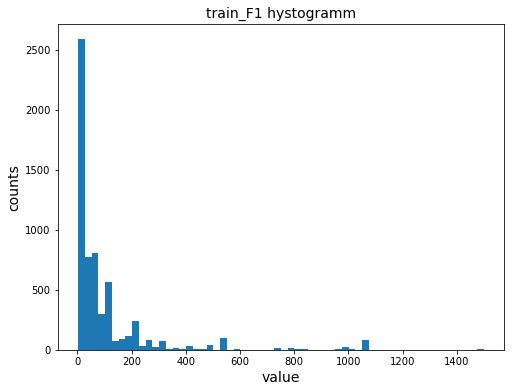

In [20]:
%matplotlib inline
plt.figure(num=1, figsize=(8, 6))
plt.title('train_F1 hystogramm', size=14)
plt.xlabel('value', size=14)
plt.ylabel('counts', size=14)
plt.hist(train['F1'], bins=float(max(df.F1)/25));


In [21]:
trans_features = ['F1']
train_scaled = train.copy()
train_trans_data = train_scaled[trans_features]


In [22]:
scaler = RobustScaler()
scaler.fit(train_trans_data)
train_scaled[trans_features] = scaler.transform(train_trans_data)


In [23]:
test_scaled = test.copy()
test_trans_data = test_scaled[trans_features]
test_scaled[trans_features] = scaler.transform(test_trans_data)

#### xgboost

In [33]:
train_dmatrix = train_scaled.values
test_dmatrix = test_scaled.values

In [30]:
model = xgb.XGBClassifier(objective ='binary:logistic', random_state=1234, learning_rate = 0.1,
                max_depth = 6, alpha = 10, n_estimators = 120, eval_metric="auc")

In [31]:
model.fit(train_dmatrix, y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
       n_estimators=120, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=1234, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [37]:
test_predicted_prob = model.predict_proba(test_dmatrix)
test['probability'] = test_predicted_prob[:, 1]

In [41]:
level = 0.5
test.loc[test['probability']>level, 'predicted'] = 1 
test.loc[test['probability']<level, 'predicted'] = 0

In [46]:
accuracy_score(y_test, test.predicted)

0.76688311688311683

In [48]:
print(classification_report(y_test, test.predicted))

             precision    recall  f1-score   support

          0       0.78      0.89      0.83       991
          1       0.74      0.54      0.62       549

avg / total       0.76      0.77      0.76      1540

